In [6]:
import numpy as np
import matplotlib.pyplot as plt
#from IPython.core.display import HTML
#css_file = './custom.css'
#HTML(open(css_file, "r").read())

Here we try to solve a made up equation which has following solution:
    \begin{equation}
   \psi =  e^{i(2\pi t/T)}  sin\left(2\pi \vec{k}.\vec{x}\right)
    \end{equation}

    
  We substitute above solution in following equation:
    \begin{equation}
    \partial_t \psi - i\frac{\kappa}{2}(\nabla^2\psi) + iV\psi = 0
    \end{equation}
  
  where
  \begin{equation}
  \nabla^2V = \frac{1}{2\kappa}(|\psi|^2 - 1/2)
  \end{equation}
  
  and we get following modified equation for $\psi(t,\vec{x})$:
    \begin{equation}
    \partial_t \psi - i\frac{\kappa}{2}(\nabla^2\psi) + iV\psi = g(t,\vec{x})
    \end{equation}  
  with 
    \begin{equation}
      g(t,\vec{x}) = i\beta\psi
   \end{equation}
   where
   \begin{equation}
       \beta = \frac{-2\pi}{T} + \frac{\kappa}{2}(\frac{2\pi}{s})^2 |\vec{k}|^2 +V
   \end{equation}
  
    
    
    
    
    

In [2]:
from GPE import GPE_scalar_field
from GPE import ImEx


In [3]:
#3-d Fiducial example

# Higueras (17)
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)




def rhs_f(u,xi2,kppa,bta):
    
    vrhs = 0.5(np.square(np.abs(u))-0.5)/kppa
    v = np.ifftn(-np.fftn(vrhs,vrhs.shape)/xi2,vrhs.shape)
    
    
    
    
    
    return (1j*(bta-v)*u)

def im_rhs(psi_ft,xi2,kppa,bta):
   
    psi_ft = -psi_ft*(xi2)
    return(1j*0.5*kppa*np.fft.ifftn(psi_ft,psi_ft.shape))

def sol_err(psi,t,nx,T,max_err=-1.0):

    sol = np.exp(-1j*(2.0*t*np.pi/T))*np.sin(2.0*np.pi*nx)
    #print("sol shape",sol.shape,"psi.shape",psi.shape)
    err = np.square(np.abs(sol-psi).flatten()).sum()
    err = err/(np.square(np.abs(sol).flatten()).sum())
    if(err>max_err):
        max_err = err
    return(max_err)


def solve_3d_example(m,dt):
    L = 2.0
    
    x = np.arange(-m/2,m/2)*(L/m)
    xv,yv,zv = np.meshgrid(x,x,x)
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    xix,xiy,xiz = np.meshgrid(xi,xi,xi)
    pm = 0.1
    pn = 2.0/L
   
    nx = pn*xv+pn*yv+pn*zv
    k2 = 3.0*(pn**2)
    
    #nx = np.dot(pnv,xv)
    print("nx shape",nx.shape,"x shape",x.shape)
    
    T = 2.0*np.pi/pm
    
    
    u = np.exp(-1j*0.0)*np.sin(2.0*np.pi*nx)
    
    chk_err = sol_err(u,0.0,nx,T,-1.0)
    print("chk err ",chk_err)
   
    print(type(u),u.shape,u.dtype)
    tmax = 2.0

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)

    frames = [u.copy()]
    tt = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    

    
    
    psi = GPE_scalar_field(3,m,im_rhs,rhs_f,imx,u)
    xi2 = (xix*xix+xiy*xiy+xiz*xiz)
    lmbda = (0.5*xi2)/(3.0*pm)
    
    u2 = np.square(np.abs(u))
    vini = 0.5*(np.fft.ifftn(-np.fft.fftn(u2-0.5,u2.shape)/xi2,u.shape))/kppa;
    
    bta = (-2.0*np.pi/T)+0.5*kppa*2.0*np.pi*2.0*np.pi*k2+vini
    
    print("beta shape",bta.shape)
    
    max_err = -1.0
    
        
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            psi.update_stage_sum(k,dt)
            psi.do_fft(k,lmbda,dt)
            psi.update_K(k,xi2,pm,pn)
        psi.sum_contributions(dt)
        
        
        t = (n+1)*dt
        if np.mod(n,nplt) == 0:
            frames.append(psi.psi)
            tt.append(t)
            err = sol_err(psi.psi,t,nx,T,max_err)
            err_l.append(err)
            
            mass = psi.calc_mass()
            mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
            mass_l.append(mass)
            mass_err_l.append(mass_err)
            


    err = sol_err(psi.psi,t,nx,T,max_err)
    err_l.append(err)
            
    mass = psi.calc_mass()
    mass_err = (mass-psi.mass_ini)/psi.mass_ini
            
    mass_l.append(mass)
    mass_err_l.append(mass_err)
       
    return frames, x,err_l,mass_l,mass_err_l

In [8]:

dt = 0.01


frames, x, err_l, mass_l,mass_err_l = solve_3d_example(64,dt)

nx shape (64, 64, 64) x shape (64,)
chk err  0.0
<class 'numpy.ndarray'> (64, 64, 64) complex128
class shapes (64, 64, 64) (3, 64, 64, 64)
(64, 64, 64) (64, 64, 64)


In [72]:
import numpy as np

m=64
L=30.0
#ur = np.ones((m,))


p=20/L

x = np.arange(0,m)*(L/m)
xv,yv,zv = np.meshgrid(x,x,x)
xi = np.fft.fftfreq(m)*m*2*np.pi/L
xix,xiy,xiz = np.meshgrid(xi,xi,xi)
x2 = xv**2+yv**2+zv**2
xi2 = xi*xi# xix**2+xiy**2+xiz**2

ur =np.sin(2.0*np.pi*p*x)
u = ur+0.0*1j

kppa = 1.0
vrhs = kppa*(np.square(np.abs(u))-0.5)
v = np.fft.ifftn(-xi2*np.fft.fftn(vrhs,vrhs.shape),vrhs.shape)


vf = -x2/(kppa*6.0)

v = np.real(v).flatten()
vf = vf.flatten()

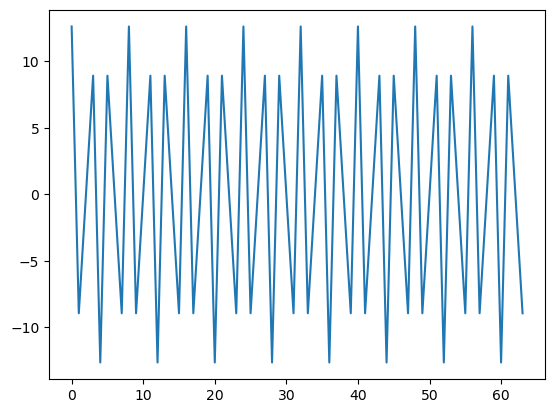

In [73]:
plt.plot(v)

In [74]:
np.sum(np.square(np.abs(u)))*(L/m)

15.000000000000014

In [75]:
np.sum(vrhs)

2.5757174171303632e-14

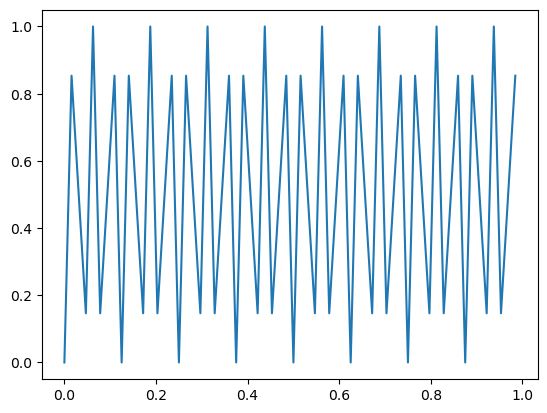

In [61]:
plt.plot(x,np.square(np.abs(u)))

In [40]:
rr = np.abs(r).flatten()

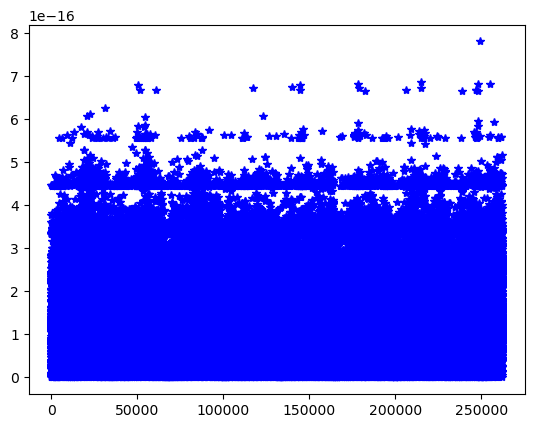

In [41]:
plt.plot(rr,"b*")